<font size=8>Create Synthetic WOD</font>

This notebook subsamples the output of a numerical ocean model using the locations of observations from the World Ocean Database
The xESMF tool is used to subsample the model temperature and salinity fields



In [1]:
import os
import dask
import numpy as np
import pandas as pd
import dask.array as dask
import dask.bag as db
from matplotlib import pyplot as plt
import xarray 
import xesmf 

In [2]:
xarray.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34951,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:46605,Total threads: 1
Dashboard: /proxy/33467/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36077,


Load the model field (here from the 0.1 degree COSIMA model suite)

In [3]:
model_data_base_path = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/'

model_subdirs = os.listdir(model_data_base_path)
model_subdirs.sort()

model_temperature_files = []

for i_subdir in model_subdirs:
    #print(i_subdir)
    if os.path.isdir(os.path.join(model_data_base_path,i_subdir)) and "output" in i_subdir:
        model_output_directory = os.path.join(model_data_base_path,i_subdir,'ocean')
        model_output_dir_contents = os.listdir(model_output_directory)
        
        model_output_dir_contents.sort()
        
        for i_file in model_output_dir_contents:
            
            if os.path.isfile(os.path.join(model_output_directory,i_file)) and i_file.startswith("ocean-3d-temp-1-daily-mean"):
                #print(i_file)
                model_temperature_files.append(os.path.join(model_output_directory,i_file))
        
        #print(i_subdir)


In [6]:
model_temperature_dataset = xarray.open_mfdataset(model_temperature_files)#.to_dask() #,concat_dim='time')

In [7]:
grid010 = xarray.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

In [8]:
model_temperature_dataset = model_temperature_dataset.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
model_temperature_dataset = model_temperature_dataset.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                                                              'geolon_t': 'longitude', 'geolat_t': 'latitude'})


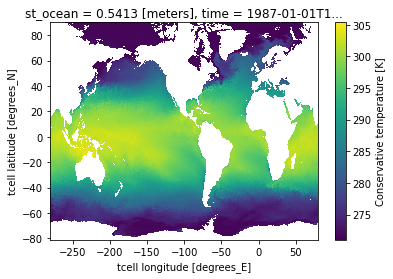

In [9]:
LAT_LIMIT_SOUTH = -50
LAT_LIMIT_NORTH = 0

LON_LIMIT_WEST = -280
LON_LIMIT_EAST = -180

model_longitude_grid_offset = -280



model_temperature_dataset = model_temperature_dataset.sel(
    x=slice(LON_LIMIT_WEST,LON_LIMIT_EAST),
    y=slice(LAT_LIMIT_SOUTH,LAT_LIMIT_NORTH),time=slice("2018",'2019'))

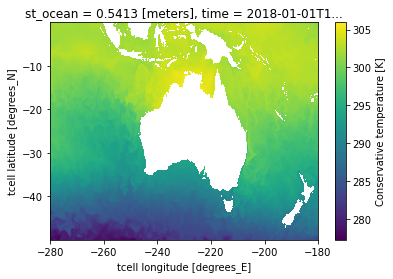

In [10]:
model_temperature_dataset['temp'][0,0,:,:].plot()

Load the World Ocean Database data


In [11]:
WOD_base_file_path ='/g/data/ul08/WOD_2018'

year = 2018
WOD_file_name_stem = 'wod_'


obs_platform_type = ['ctd','xbt','pfl','mrb','gld','drb','osd']

WOD_object = dict(zip(obs_platform_type, [None]*len(obs_platform_type)))


for i_platform_type in obs_platform_type:
    
    WOD_object[i_platform_type] = xarray.open_dataset(os.path.join(WOD_base_file_path,str(2018),
                                                                   WOD_file_name_stem + i_platform_type + '_' + str(year) + '.nc') )
    


In [15]:
ds_WOD_stations = xarray.Dataset()
ds_WOD_stations['longitude'] = xarray.DataArray(data=WOD_lon, dims=('casts'))
ds_WOD_stations['latitude'] = xarray.DataArray(data=WOD_lat, dims=('casts'))
ds_WOD_stations['time'] = xarray.DataArray(data=WOD_object[platform_type]['time'].values, dims=('casts'))

ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['longitude']>-280,
                                                       ds_WOD_stations['longitude']<-180),drop=True)
ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['latitude']>-50,
                                                       ds_WOD_stations['latitude']<0),drop=True)



KeyboardInterrupt



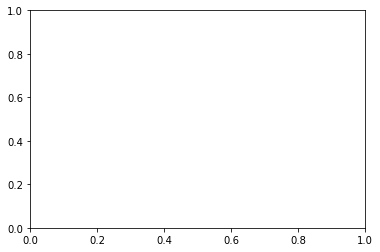

In [20]:
plt.contourf(model_temperature_dataset['temp']['x'],model_temperature_dataset['temp']['y'],
             model_temperature_dataset['temp'][0,0,:,:],25)
plt.scatter(ds_WOD_stations['longitude'],ds_WOD_stations['latitude'])

#plt.scatter(WOD_lon,WOD_lat,s=10)


In [13]:
model_temperature_dataset['st_ocean'][50]

<xarray.DataArray 'st_ocean' ()>
array(1453.38439941)
Coordinates:
    st_ocean  float64 1.453e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean

In [16]:
max_depth = 2000

n_levels = model_temperature_dataset['st_ocean'].sel(st_ocean=slice(0,max_depth)).size
KELVIN_TO_CELSIUS = -273.15



for i_level in range(50,n_levels):
    print(i_level)
    model_temperature_level = model_temperature_dataset['temp'].isel(st_ocean=i_level).load() 
    model_temperature_level = model_temperature_level + KELVIN_TO_CELSIUS
    for i_platform_type in obs_platform_type:
        
        
        print('Platform type:', i_platform_type)
        WOD_lat = WOD_object[i_platform_type]['lat'].copy().values
        WOD_lon = WOD_object[i_platform_type]['lon'].copy().values
        WOD_lon[WOD_lon>90] = WOD_lon[WOD_lon>90] - (270+90) 
    
        ds_WOD_stations = xarray.Dataset()
        ds_WOD_stations['longitude'] = xarray.DataArray(data=WOD_lon, dims=('casts'))
        ds_WOD_stations['latitude'] = xarray.DataArray(data=WOD_lat, dims=('casts'))
        ds_WOD_stations['time'] = xarray.DataArray(data=WOD_object[i_platform_type]['time'].values, dims=('casts'))

        ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['longitude']>-280,
                                                       ds_WOD_stations['longitude']<-180),drop=True)
        ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['latitude']>-50,
                                                       ds_WOD_stations['latitude']<0),drop=True)
    
        n_casts  = ds_WOD_stations['casts'].size
        if n_casts !=0:
            
        
            regridder = xesmf.Regridder(model_temperature_level, ds_WOD_stations, 'bilinear', locstream_out=True) #,reuse_weights=True)
        
            WOD_temperature_synthetic_level = regridder(model_temperature_level)
        
            imtermediate_output_file_name = 'WOD_synthetic_' + i_platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc'
            print('Writing to: ', imtermediate_output_file_name)
            WOD_temperature_synthetic_level.to_netcdf(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging_test_curvilinear', 
                                                           imtermediate_output_file_name) ) 
        

50
Platform type: ctd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_ctd_2018_level_50.nc
Platform type: xbt


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_xbt_2018_level_50.nc
Platform type: pfl


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_pfl_2018_level_50.nc
Platform type: mrb


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_mrb_2018_level_50.nc
Platform type: gld


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_gld_2018_level_50.nc
Platform type: drb
Platform type: osd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_osd_2018_level_50.nc
51
Platform type: ctd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_ctd_2018_level_51.nc
Platform type: xbt


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_xbt_2018_level_51.nc
Platform type: pfl


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_pfl_2018_level_51.nc
Platform type: mrb


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_mrb_2018_level_51.nc
Platform type: gld


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_gld_2018_level_51.nc
Platform type: drb
Platform type: osd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_osd_2018_level_51.nc
52
Platform type: ctd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_ctd_2018_level_52.nc
Platform type: xbt


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_xbt_2018_level_52.nc
Platform type: pfl


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_pfl_2018_level_52.nc
Platform type: mrb


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_mrb_2018_level_52.nc
Platform type: gld


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_gld_2018_level_52.nc
Platform type: drb
Platform type: osd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_osd_2018_level_52.nc
53
Platform type: ctd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_ctd_2018_level_53.nc
Platform type: xbt


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_xbt_2018_level_53.nc
Platform type: pfl


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_pfl_2018_level_53.nc
Platform type: mrb


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_mrb_2018_level_53.nc
Platform type: gld


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_gld_2018_level_53.nc
Platform type: drb
Platform type: osd


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Writing to:  WOD_synthetic_osd_2018_level_53.nc


In [15]:
n_levels

54

In [18]:


WOD_synthetic_all_platforms = {}
n_levels=54
for i_platform_type in obs_platform_type:

        print('Platform type:', i_platform_type)
        WOD_lat = WOD_object[i_platform_type]['lat'].copy().values
        WOD_lon = WOD_object[i_platform_type]['lon'].copy().values
        WOD_lon[WOD_lon>90] = WOD_lon[WOD_lon>90] - (270+90) 
    
        WOD_temperature_synthetic = xarray.Dataset()
        WOD_temperature_synthetic['longitude'] = xarray.DataArray(data=WOD_lon, dims=('casts'))
        WOD_temperature_synthetic['latitude'] = xarray.DataArray(data=WOD_lat, dims=('casts'))
        WOD_temperature_synthetic['time'] = xarray.DataArray(data=WOD_object[i_platform_type]['time'].values, dims=('casts'))

        WOD_temperature_synthetic = WOD_temperature_synthetic.where(np.logical_and(WOD_temperature_synthetic['longitude']>-280,
                                                       WOD_temperature_synthetic['longitude']<-180),drop=True)
        WOD_temperature_synthetic = WOD_temperature_synthetic.where(np.logical_and(WOD_temperature_synthetic['latitude']>-50,
                                                       WOD_temperature_synthetic['latitude']<0),drop=True)
        
        n_casts  = WOD_temperature_synthetic['casts'].size

        WOD_temperature_synthetic['temp'] = xarray.DataArray(np.zeros([n_casts,n_levels]),dims=['casts','depth'],coords={'casts':WOD_temperature_synthetic['casts'],
                                                                                                                       'depth':model_temperature_dataset['st_ocean'].isel(st_ocean=slice(0,n_levels)).values})
        if n_casts != 0: 
            for i_level in range(0,n_levels):
            
            #Get the slice for the current synthetic layer
                WOD_temperature_synthetic_level = xarray.open_dataset(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging_test_curvilinear', 
                                                           'WOD_synthetic_' + i_platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') )
                WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level['__xarray_dataarray_variable__'].sel(time=WOD_temperature_synthetic['time'],method='nearest')
                WOD_temperature_synthetic_level.close()
            WOD_synthetic_all_platforms[i_platform_type] = WOD_temperature_synthetic
            WOD_synthetic_all_platforms[i_platform_type].to_netcdf(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/2018','synthetic_wod_2018_' + i_platform_type + '.nc'))

Platform type: ctd
Platform type: xbt
Platform type: pfl
Platform type: mrb
Platform type: gld
Platform type: drb
Platform type: osd


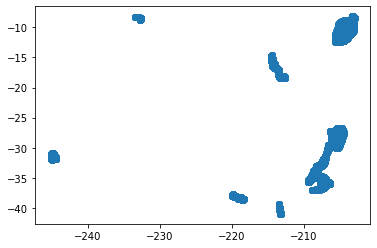

In [20]:
plt.scatter(WOD_synthetic_all_platforms['gld']['longitude'],WOD_synthetic_all_platforms['gld']['latitude'])

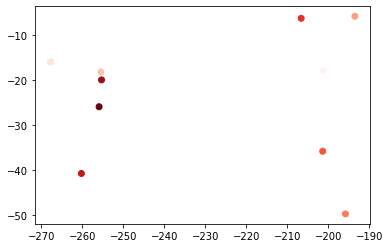

In [40]:
plt.scatter(WOD_synthetic_all_platforms['pfl']['longitude'][0:10],WOD_synthetic_all_platforms['pfl']['latitude'][0:10],c=np.arange(0,10),cmap='Reds')

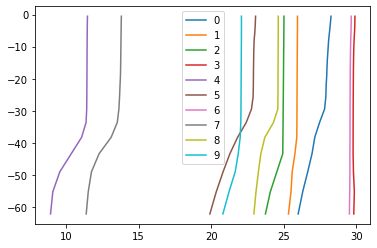

In [42]:
for i_cast in range(0,10):
    plt.plot(WOD_synthetic_all_platforms['pfl']['temp'][i_cast,:],-WOD_synthetic_all_platforms['pfl']['depth'],label=i_cast)
plt.legend()

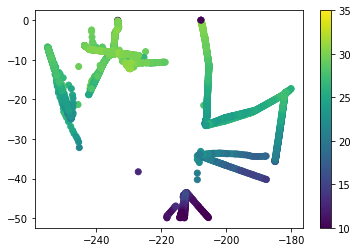

In [60]:
plt.scatter(WOD_temperature_synthetic['longitude'],WOD_temperature_synthetic['latitude'],c=WOD_temperature_synthetic['temp'][:,0],vmin=10,vmax=35)
plt.colorbar()

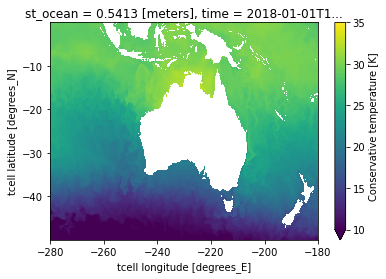

In [62]:
model_temperature_level[0,:,:].plot(vmin=10,vmax=35)

In [22]:
model_temperature_level

<xarray.Dataset>
Dimensions:         (longitude: 1000, latitude: 579, st_edges_ocean: 76,
                     time: 365, nv: 2)
Coordinates:
  * longitude       (longitude) float64 -279.9 -279.8 -279.7 ... -180.1 -180.0
  * latitude        (latitude) float64 -49.96 -49.9 -49.83 ... -0.25 -0.15 -0.05
    st_ocean        float64 0.5413
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, latitude, longitude) float32 279.1 278.9 ... 302.9
    average_T1      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
    average_T2      (time) datetime64[ns] 2018-01-02 2018-01-03 ... 2019-01-01
    average_DT      (time) timedelta64[ns] 1 days 1 days ... 1 days 1 days
    time_bounds     (time, nv) timedelta64[ns] 43099 days ... 43464 days
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [33]:
regridder.to_netcdf('/g/data4/ul08/CARS_v2/regrid_weights_xbt.nc')

'/g/data4/ul08/CARS_v2/regrid_weights_xbt.nc'

In [23]:
test_xbt.compute()

NameError: name 'test_xbt' is not defined

In [31]:
unique_days = np.unique(ds_WOD_stations['time.dayofyear'])

In [46]:
WOD_time_index

<xarray.DataArray 'dayofyear' (casts: 3240)>
array([ True, False, False, ..., False, False, False])
Coordinates:
    lat      (casts) float32 -17.83 -16.73 -15.87 ... -14.03 -10.97 -17.31
    lon      (casts) float32 118.3 118.9 119.4 119.8 ... 108.6 107.9 106.7 118.5
Dimensions without coordinates: casts

In [51]:
ds_WOD_stations_dayofyear

<xarray.Dataset>
Dimensions:    (casts: 1)
Coordinates:
    lat        (casts) float32 -17.83
    lon        (casts) float32 118.3
Dimensions without coordinates: casts
Data variables:
    longitude  (casts) float32 -251.7
    latitude   (casts) float32 -17.83
    time       (casts) datetime64[ns] 2018-01-05T23:19:00.003204096

In [47]:
ds_WOD_stations

<xarray.Dataset>
Dimensions:    (casts: 3240)
Coordinates:
    lat        (casts) float32 -17.83 -16.73 -15.87 ... -14.03 -10.97 -17.31
    lon        (casts) float32 118.3 118.9 119.4 119.8 ... 107.9 106.7 118.5
Dimensions without coordinates: casts
Data variables:
    longitude  (casts) float32 -251.7 -251.1 -250.6 ... -262.0 -263.3 -251.5
    latitude   (casts) float32 -17.83 -16.73 -15.87 ... -14.03 -10.97 -17.31
    time       (casts) datetime64[ns] 2018-01-05T23:19:00.003204096 ... 2018-...

In [ ]:
regridder = xesmf.Regridder(model_temperature, ds_WOD_stations, 'bilinear', locstream_out=True)


In [38]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_579x1000_1x383.nc 
Reuse pre-computed weights? False 
Input grid shape:           (579, 1000) 
Output grid shape:          (1, 383) 
Periodic in longitude?      False

In [39]:
WOD_temperature_synthetic = regridder(model_temperature).compute()



2023-01-31 17:01:19,774 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.50 GiB
2023-01-31 17:01:19,871 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.50 GiB
2023-01-31 17:01:19,971 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KeyboardInterrupt: 

2023-01-31 17:02:04,965 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-01-31 17:02:04,966 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-01-31 17:02:04,967 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-01-31 17:02:04,969 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing


In [24]:
WOD_temperature_synthetic

<xarray.Dataset>
Dimensions:   (time: 11688, st_ocean: 75, casts: 7930)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1987-01-01T12:00:00 ... 2018-12-31T12:00:00
    lon       (casts) float32 101.5 101.5 102.0 101.4 ... 112.9 114.1 117.7
    lat       (casts) float32 -4.24 -4.236 -4.0 -4.32 ... -65.15 -65.05 -64.92
Dimensions without coordinates: casts
Data variables:
    temp      (time, st_ocean, casts) float32 dask.array<chunksize=(5, 75, 7930), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [109]:
model_temperature

<xarray.Dataset>
Dimensions:    (st_ocean: 75, time: 7930, y: 579, x: 1000)
Coordinates:
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
    latitude   (y, x) float64 dask.array<chunksize=(579, 1000), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(579, 1000), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    temp       (time, st_ocean, y, x) float32 dask.array<chunksize=(8, 75, 579, 1000), meta=np.ndarray>

2023-01-31 15:43:51,289 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing


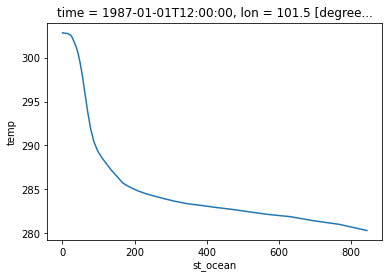

In [107]:
WOD_temperature_synthetic['temp'][0,:,0].plot()